In [ ]:
# prompt: import drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
import os
import pickle
import ast
import random
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

In [ ]:
# Define the base folder path to your project directory in Google Drive
Ds_project_folder_path = '/content/drive/MyDrive/DS_project/Data/'
unsupervised_path = '6_Unsupervised_clustering/kmeans_30mixed/'
classification_path = '7_classification/'

In [ ]:
classification_result_file_path = Ds_project_folder_path + unsupervised_path

In [ ]:
save_path = Ds_project_folder_path + classification_path

In [ ]:
model_grid = {
    'LR': (LogisticRegression(max_iter=1000), {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'verbose': [0]
    }),
    'LDA': (LinearDiscriminantAnalysis(), {
        'solver': ['svd', 'lsqr', 'eigen']
    }),
    'KNN': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }),
    'CART': (DecisionTreeClassifier(), {
        'max_depth': [3, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }),
    'NB': (GaussianNB(), {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    }),
    'SVM': (SVC(), {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto'],
        'degree': [2, 3, 4],
        'probability': [True],
        'verbose': [False]
    }),
    'RF': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5],
        'criterion': ['gini', 'entropy'],
        'verbose': [0]
    }),
    'QDA': (QuadraticDiscriminantAnalysis(), {
        'reg_param': [0.0, 0.1, 0.5, 1.0]
    }),
    'CatBoost': (CatBoostClassifier(verbose=0, logging_level='Silent'), {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 200],
        'logging_level': ['Silent']
    }),
    'XGB': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0), {
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'subsample': [0.8, 1.0],
        'verbosity': [0]
    }),
    'LGBM': (LGBMClassifier(), {
        'num_leaves': [31, 64, 128],
        'learning_rate': [0.01, 0.1, 0.3],
        'n_estimators': [100, 200],
        'boosting_type': ['gbdt', 'dart'],
        'verbose': [-1]
    })
}

In [ ]:
def create_synthetic_mofa_data(n_samples=600, n_features=50, n_clusters=4):
    cluster_sizes = [n_samples // n_clusters] * n_clusters
    centroids = np.random.randn(n_clusters, n_features) * 3
    cluster_dfs = []
    start_id = 0

    for cluster_id, size in enumerate(cluster_sizes):
        data = np.random.randn(size, n_features) + centroids[cluster_id]
        df = pd.DataFrame(data, columns=[f"Factor{i}" for i in range(1, n_features + 1)])
        df["cluster"] = cluster_id
        df["sample_id"] = [f"TCGA-{start_id + i:04d}" for i in range(size)]
        df = df.set_index("sample_id")
        cluster_dfs.append(df)
        start_id += size

    return pd.concat(cluster_dfs)

In [ ]:
def split_and_format_simu_mofa_all(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
    factor_cols = [col for col in df.columns if col.startswith("Factor")]
    train_list, val_list, test_list = [], [], []

    for cluster_id in df["cluster"].unique():
        cluster_data = df[df["cluster"] == cluster_id]
        train_data, temp_data = train_test_split(cluster_data, test_size=(1 - train_ratio), random_state=random_state)
        val_size = val_ratio / (val_ratio + test_ratio)
        val_data, test_data = train_test_split(temp_data, test_size=(1 - val_size), random_state=random_state)
        train_list.append(train_data)
        val_list.append(val_data)
        test_list.append(test_data)

    def convert(df_part, seed):
        np.random.seed(seed)
        return pd.DataFrame({
            "sample_id": df_part.index,
            "Factor_Array": df_part[factor_cols].apply(lambda row: row.to_numpy(), axis=1),
            "cluster": df_part["cluster"].values,
            "label": np.random.randint(0, 2, size=len(df_part))
        })

    return (
        convert(pd.concat(train_list), seed=random_state+1),
        convert(pd.concat(val_list),   seed=random_state+2),
        convert(pd.concat(test_list),  seed=random_state+3)
    )


In [ ]:
def split_df_by_cluster(df):
    return {cid: sub_df.reset_index(drop=True) for cid, sub_df in df.groupby("cluster")}

def manual_grid_search(model_class, param_grid, X_train, y_train, X_val, y_val):
    best_model, best_score, best_params = None, 0, None
    for params in ParameterGrid(param_grid):
        model = model_class(**params)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        try:
            score = f1_score(y_val, y_pred)
        except ValueError:
            score = 0

        if score > best_score:
            best_score = score
            best_model = model
            best_params = params

    return best_model, best_params, best_score

In [ ]:
def train_and_evaluate_dual_test(train_df, val_df, test_internal_df, test_external_df):
    train_clusters = split_df_by_cluster(train_df)
    val_clusters = split_df_by_cluster(val_df)
    internal_test_clusters = split_df_by_cluster(test_internal_df)
    external_test_clusters = split_df_by_cluster(test_external_df)
    cluster_models = {}

    all_results = []

    for cid in sorted(train_clusters.keys()):
        cluster_models[cid] = {}
        print(f"\n=== Cluster {cid} ===")

        try:
            train_data = train_clusters[cid].drop(columns=['sample_id', 'cluster'])
            val_data = val_clusters.get(cid)

            if val_data is None or train_data.empty or val_data.empty:
                print(f"Cluster {cid} skipped: training or validation data missing.")
                continue

            val_data = val_data.drop(columns=['sample_id', 'cluster'])
            test_int = internal_test_clusters.get(cid)
            test_ext = external_test_clusters.get(cid)

            test_int = test_int.drop(columns=['sample_id', 'cluster']) if test_int is not None else None
            test_ext = test_ext.drop(columns=['sample_id', 'cluster']) if test_ext is not None else None

            if "Factor_Array" not in train_data.columns or "Factor_Array" not in val_data.columns:
                print(f"Cluster {cid} skipped: missing Factor_Array in train or val.")
                continue

            X_train = np.stack(train_data["Factor_Array"].values)
            y_train = train_data["label"].values
            X_val = np.stack(val_data["Factor_Array"].values)
            y_val = val_data["label"].values

        except Exception as e:
            print(f"Cluster {cid} skipped due to error during preprocessing: {e}")
            continue

        for name, (proto_model, param_grid) in model_grid.items():
            if len(np.unique(y_train)) < 2:
                print(f"[{name}] skipped for cluster {cid}: only one class in y_train.")
                continue

            model_class = proto_model.__class__

            try:
                model, best_params, val_acc = manual_grid_search(
                    model_class, param_grid, X_train, y_train, X_val, y_val
                )

                # --- Validation Prediction & Scores ---
                y_val_pred = model.predict(X_val)
                val_f1 = f1_score(y_val, y_val_pred)
                val_precision = precision_score(y_val, y_val_pred)
                val_recall = recall_score(y_val, y_val_pred)

            except Exception as e:
                print(f"[{name}] manual_grid_search failed for cluster {cid}: {e}")
                continue

            cluster_models[cid][name] = model

            if model:
                def eval_on_test(X, y):
                    y_pred = model.predict(X)
                    try:
                        if hasattr(model, "predict_proba"):
                            y_score = model.predict_proba(X)[:, 1]
                        elif hasattr(model, "decision_function"):
                            y_score = model.decision_function(X)
                        else:
                            y_score = None
                    except Exception:
                        y_score = None

                    acc = accuracy_score(y, y_pred)
                    f1 = f1_score(y, y_pred)
                    precision = precision_score(y, y_pred)
                    recall = recall_score(y, y_pred)
                    try:
                        auroc = roc_auc_score(y, y_score) if y_score is not None else None
                    except Exception:
                        auroc = None

                    return acc, f1, precision, recall, auroc

                try:
                    acc_int, f1_int, prec_int, rec_int, auc_int = None, None, None, None, None
                    acc_ext, f1_ext, prec_ext, rec_ext, auc_ext = None, None, None, None, None

                    if test_int is not None and not test_int.empty:
                        X_test_int = np.stack(test_int["Factor_Array"].values)
                        y_test_int = test_int["label"].values
                        acc_int, f1_int, prec_int, rec_int, auc_int = eval_on_test(X_test_int, y_test_int)

                    if test_ext is not None and not test_ext.empty:
                        X_test_ext = np.stack(test_ext["Factor_Array"].values)
                        y_test_ext = test_ext["label"].values
                        acc_ext, f1_ext, prec_ext, rec_ext, auc_ext = eval_on_test(X_test_ext, y_test_ext)

                    print(f"{name} | Val f1: {val_f1:.4f} | "
                          f"Internal Test f1: {f1_int:.4f} | External Test f1: {f1_ext:.4f}")

                    all_results.append({
                        'cluster': cid,
                        'model': name,
                        'val_acc': val_acc,
                        'val_f1': val_f1,
                        'val_precision': val_precision,
                        'val_recall': val_recall,
                        'int_test_acc': acc_int,
                        'int_f1': f1_int,
                        'int_precision': prec_int,
                        'int_recall': rec_int,
                        'int_auroc': auc_int,
                        'ext_test_acc': acc_ext,
                        'ext_f1': f1_ext,
                        'ext_precision': prec_ext,
                        'ext_recall': rec_ext,
                        'ext_auroc': auc_ext,
                        'params': best_params
                    })

                except Exception as e:
                    print(f"[{name}] Evaluation error for cluster {cid}: {e}")

    return cluster_models, pd.DataFrame(all_results)

In [ ]:
def bootstrap_and_evaluate(train_df, val_df, test_internal_df, test_external_df, n_iter=100, seed=42):
    all_bootstrap_results = []

    cluster_ids = train_df['cluster'].unique()

    for i in range(n_iter):
        print(f"\n🌀 Bootstrap Iteration {i+1}/{n_iter}")

        random.seed(seed + i)
        np.random.seed(seed + i)

        boot_train_df = []

        for cid in cluster_ids:
            cluster_data = train_df[train_df['cluster'] == cid]
            boot_sample = cluster_data.sample(n=len(cluster_data), replace=True, random_state=seed+i)
            boot_train_df.append(boot_sample)

        boot_train_df = pd.concat(boot_train_df).reset_index(drop=True)

        cluster_models, bootstrap_result = train_and_evaluate_dual_test(
            boot_train_df,
            val_df,
            test_internal_df,
            test_external_df
        )

        bootstrap_result["bootstrap_iter"] = i
        all_bootstrap_results.append(bootstrap_result)

    all_results_df = pd.concat(all_bootstrap_results).reset_index(drop=True)
    return cluster_models, all_results_df

In [ ]:
def convert_latent_df(latent_df, cluster_df):
    factor_df = latent_df.copy().reset_index()

    factor_df = factor_df.rename(columns={"latent_vector": "Factor_Array"})

    cluster_df = cluster_df.rename(columns={"sample": "sample_id"})
    cluster_df = cluster_df.drop(columns = 'label')
    merged = pd.merge(factor_df, cluster_df, on="sample_id", how="left")
    merged["label"] = merged["label"].map({"GBM": 0, "LGG": 1})

    return merged

### Data import

In [ ]:
data_integration_file_path="/content/drive/MyDrive/DS_project/Data/5_Inter-cohort_preprocessing/5.5Multi-omics_integration/Z_output/"

In [ ]:
with open(data_integration_file_path + '30mixed_train_latent_output.pickle', 'rb') as f:
    train_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_val_latent_output.pickle', 'rb') as f:
    val_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_external_test_latent_output.pickle', 'rb') as f:
    external_test_latent_output = pickle.load(f)

with open(data_integration_file_path + '30mixed_internal_test_latent_output.pickle', 'rb') as f:
    internal_test_latent_output = pickle.load(f)

In [ ]:
train_data_df = pd.DataFrame(train_latent_output)
val_data_df = pd.DataFrame(val_latent_output)
external_test_data_df = pd.DataFrame(external_test_latent_output)
internal_test_data_df = pd.DataFrame(internal_test_latent_output)

In [ ]:
cluster_list = []
for i in range(2, 7):
  cluster_list.append('k_'+str(i))

### base_line model selection using Bootstrap

In [ ]:
base_train_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(train_data_df['sample_id'].to_list(), train_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_val_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(val_data_df['sample_id'].to_list(), val_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_external_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(external_test_data_df['sample_id'].to_list(), external_test_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_internal_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(internal_test_data_df['sample_id'].to_list(), internal_test_data_df['label'].to_list())], columns = ['sample','cluster','label' ])

In [ ]:
base_train_data = convert_latent_df(train_data_df, base_train_cluster_label)
base_val_data = convert_latent_df(val_data_df, base_val_cluster_label)
base_external_test_data = convert_latent_df(external_test_data_df, base_external_cluster_label)
base_internal_test_data = convert_latent_df(internal_test_data_df, base_internal_cluster_label)

In [ ]:
for s_i in range(2,101):
  cluster_models, boot_results = bootstrap_and_evaluate(base_train_data,base_val_data,base_internal_test_data,base_external_test_data,n_iter=1,seed=42+s_i)
  boot_results.to_csv(save_path +'base_line/' +str(s_i) + '_mixed30_base_line_result.csv')

In [ ]:
base_line_boot_results_list = [pd.read_csv(save_path +'base_line/' +str(s_i)+ '_mixed30_base_line_result.csv') for s_i in range(1,101)]
base_line_boot_results_df = pd.concat(base_line_boot_results_list, ignore_index=True)

In [ ]:
base_line_summary_all = []
base_line_model_data_for_box_plot = []
#metrics = ['val_acc',	'val_f1',	'val_precision',	'val_recall', 'int_test_acc',	'int_f1',	'int_precision',	'int_recall',	'int_auroc',	'ext_test_acc',	'ext_f1',	'ext_precision',	'ext_recall',	'ext_auroc']
metrics = ['val_f1']
for clust_id, df_cluster in base_line_boot_results_df.groupby("cluster"):
    df_filled = []

    for model_name, df_model in df_cluster.groupby("model"):
        current_n = len(df_model)
        missing_n = 100 - current_n

        df_model_copy = df_model.copy()

        if missing_n > 0:

            zero_row = {col: 0 for col in metrics}
            zero_row['model'] = model_name
            zero_row['cluster'] = clust_id

            df_zeros = pd.DataFrame([zero_row] * missing_n)
            df_model_copy = pd.concat([df_model_copy, df_zeros], ignore_index=True)

        df_filled.append(df_model_copy)

    df_cluster_filled = pd.concat(df_filled, ignore_index=True)
    base_line_model_data_for_box_plot.append(df_cluster_filled)

    summary = df_cluster_filled.groupby('model')[metrics].agg(['mean', 'std'])
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.reset_index()
    summary['cluster'] = clust_id

    base_line_summary_all.append(summary)

In [ ]:
base_line_model_data_for_box_plot = pd.concat(base_line_model_data_for_box_plot, ignore_index=True)

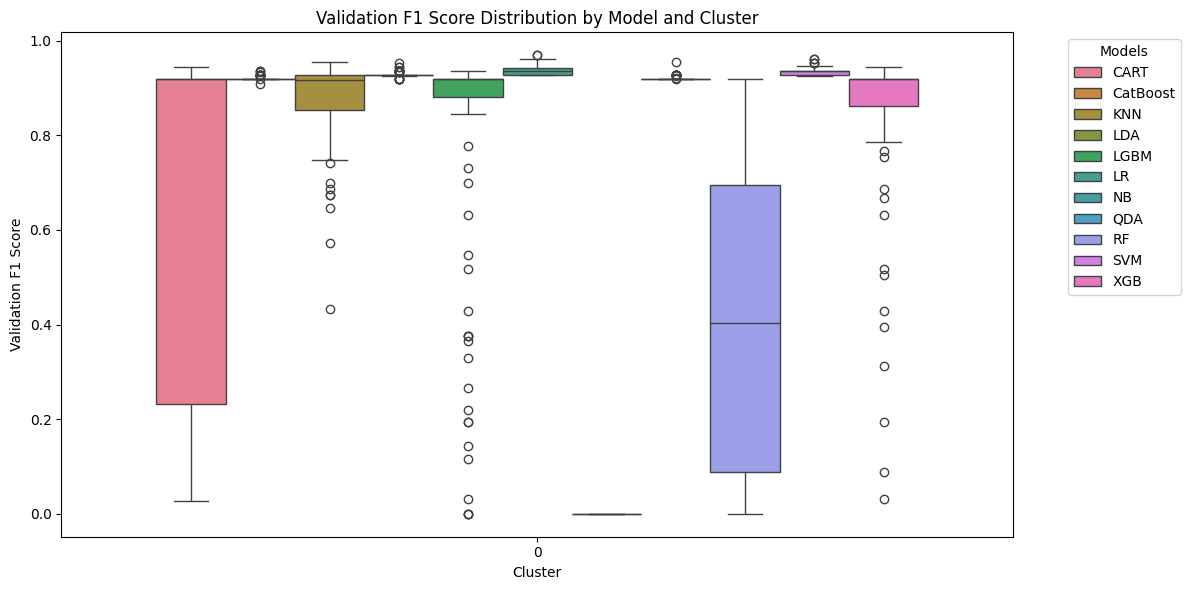

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=base_line_model_data_for_box_plot, x='cluster', y='val_f1', hue='model')
plt.title('Validation F1 Score Distribution by Model and Cluster')
plt.xlabel('Cluster')
plt.ylabel('Validation F1 Score')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
for model_name, model_data in base_line_model_data_for_box_plot[base_line_model_data_for_box_plot['cluster'] == 0].groupby("model"):
  print(model_name, model_data['val_f1'].mean(axis = 0), model_data['val_f1'].std(axis = 0))

CART 0.6924638728764506 0.34373132363932063
CatBoost 0.9205443143391784 0.0037117408289372073
KNN 0.8779361619048577 0.08707383854629236
LDA 0.9284916665691216 0.005164666689200727
LGBM 0.7877602329113798 0.26778494638819317
LR 0.9374512622936543 0.010195035646927914
NB 0.0 0.0
QDA 0.9200205220709279 0.004861090866295408
RF 0.4105681909936547 0.3141991269065007
SVM 0.9354808644092186 0.0070138723063668616
XGB 0.8466021373769449 0.1756514039354837


### Model selection using Bootstrap

In [ ]:
training_types = ['complete']

In [ ]:
result = {}
k = 'k_3'
for training_type in training_types:
  #for k in cluster_list:
  print(training_type, k)
  train_cluster_label = pd.read_csv(classification_result_file_path + str(k) + '/train_cluster_labels_consensus_' + training_type + '.csv')
  val_cluster_label = pd.read_csv(classification_result_file_path + str(k) + '/val_cluster_labels_consensus_' + training_type + '.csv')
  external_cluster_label = pd.read_csv(classification_result_file_path + str(k) + '/external_test_cluster_labels_consensus_' + training_type + '.csv')
  internal_cluster_label = pd.read_csv(classification_result_file_path + str(k) + '/internal_test_cluster_labels_consensus_' + training_type + '.csv')

  train_data = convert_latent_df(train_data_df, train_cluster_label)
  val_data = convert_latent_df(val_data_df, val_cluster_label)
  external_test_data = convert_latent_df(external_test_data_df, external_cluster_label)
  internal_test_data = convert_latent_df(internal_test_data_df, internal_cluster_label)
  for s_i in range(51,76):
    cluster_models, results_df = bootstrap_and_evaluate(train_data, val_data, internal_test_data, external_test_data,n_iter=1,seed=42+s_i)
    results_df.to_csv(save_path +'mixed30/k_3/' + training_type + '_' +str(s_i) + '_result.csv')

In [ ]:
k_3_clustering_boot_results_list = [pd.read_csv(save_path +'mixed30/k_3/' + training_types[0] + '_' +str(s_i) + '_result.csv') for s_i in range(1,101)]
k_3_clustering_boot_results_df = pd.concat(k_3_clustering_boot_results_list, ignore_index=True)

In [ ]:
k_3cluster_summary_all = []
model_data_for_box_plot = []
#metrics = ['val_acc',	'val_f1',	'val_precision',	'val_recall', 'int_test_acc',	'int_f1',	'int_precision',	'int_recall',	'int_auroc',	'ext_test_acc',	'ext_f1',	'ext_precision',	'ext_recall',	'ext_auroc']
metrics = ['val_f1']
for clust_id, df_cluster in k_3_clustering_boot_results_df.groupby("cluster"):
    df_filled = []

    for model_name, df_model in df_cluster.groupby("model"):
        current_n = len(df_model)
        missing_n = 100 - current_n

        df_model_copy = df_model.copy()

        if missing_n > 0:
            zero_row = {col: 0 for col in metrics}
            zero_row['model'] = model_name
            zero_row['cluster'] = clust_id

            df_zeros = pd.DataFrame([zero_row] * missing_n)
            df_model_copy = pd.concat([df_model_copy, df_zeros], ignore_index=True)

        df_filled.append(df_model_copy)

    df_cluster_filled = pd.concat(df_filled, ignore_index=True)
    model_data_for_box_plot.append(df_cluster_filled)

    summary = df_cluster_filled.groupby('model')[metrics].agg(['mean', 'std'])
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.reset_index()
    summary['cluster'] = clust_id

    k_3cluster_summary_all.append(summary)

In [ ]:
model_data_for_box_plot = pd.concat(model_data_for_box_plot, ignore_index=True)

In [ ]:
print('cluster 0')
for model_name, model_data in model_data_for_box_plot[model_data_for_box_plot['cluster'] == 0].groupby("model"):
  print(model_name, model_data['val_f1'].mean(axis = 0), model_data['val_f1'].std(axis = 0))

print('------------------')
print('cluster 1')

for model_name, model_data in model_data_for_box_plot[model_data_for_box_plot['cluster'] == 1].groupby("model"):
  print(model_name, model_data['val_f1'].mean(axis = 0), model_data['val_f1'].std(axis = 0))

print('------------------')
print('cluster 2')

for model_name, model_data in model_data_for_box_plot[model_data_for_box_plot['cluster'] == 2].groupby("model"):
  print(model_name, model_data['val_f1'].mean(axis = 0), model_data['val_f1'].std(axis = 0))

cluster 0
CART 0.8246865323658251 0.3325979899753715
CatBoost 1.0 0.0
KNN 1.0 0.0
LDA 0.8149988674420456 0.34349490324436066
LGBM 1.0 0.0
LR 1.0 0.0
QDA 0.9687740487740487 0.16638355907237287
RF 0.8959498339981077 0.1994664290259698
SVM 1.0 0.0
XGB 0.9997435897435898 0.002564102564102555
------------------
cluster 1
CART 0.45635948921547764 0.4620227058342329
CatBoost 0.9082633288392645 0.1210762849935449
KNN 0.9378520625889044 0.005130515321430671
LDA 0.7676672730456872 0.3388129855734666
LGBM 0.8925952534272397 0.20032908762801338
LR 0.9991780821917808 0.003269633651725246
QDA 0.9436530184916343 0.014044364619941104
RF 0.17294236858290493 0.2955073469692575
SVM 0.9987633181126333 0.004417863191414149
XGB 0.9225845236665178 0.1281639369465326
------------------
cluster 2
CART 0.35254885958023435 0.16627463977816495
CatBoost 0.20941387559808614 0.13497063777837157
KNN 0.38236092973118024 0.17580499407788508
LDA 0.026000000000000002 0.0675995337979263
LGBM 0.17885858585858586 0.09495212

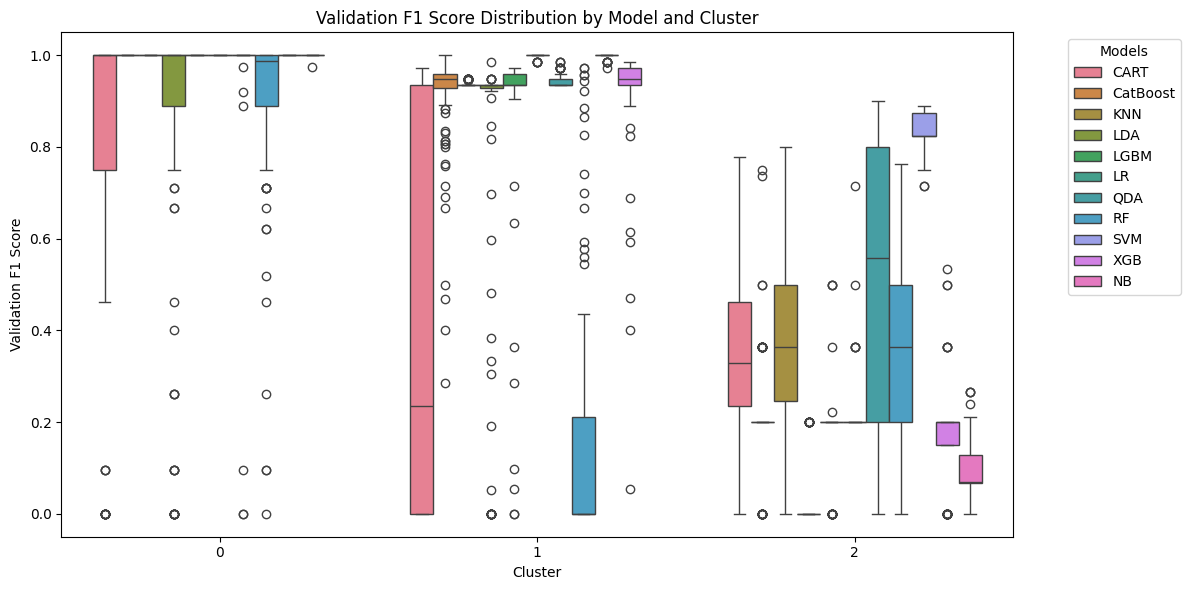

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=model_data_for_box_plot, x='cluster', y='val_f1', hue='model')
plt.title('Validation F1 Score Distribution by Model and Cluster')
plt.xlabel('Cluster')
plt.ylabel('Validation F1 Score')
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Test Dataset

In [ ]:
base_train_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(train_data_df['sample_id'].to_list(), train_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_val_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(val_data_df['sample_id'].to_list(), val_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_external_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(external_test_data_df['sample_id'].to_list(), external_test_data_df['label'].to_list())], columns = ['sample','cluster','label' ])
base_internal_cluster_label = pd.DataFrame([ [sample_id, 0, label] for sample_id, label in zip(internal_test_data_df['sample_id'].to_list(), internal_test_data_df['label'].to_list())], columns = ['sample','cluster','label' ])

base_train_data = convert_latent_df(train_data_df, base_train_cluster_label)
base_val_data = convert_latent_df(val_data_df, base_val_cluster_label)
base_external_test_data = convert_latent_df(external_test_data_df, base_external_cluster_label)
base_internal_test_data = convert_latent_df(internal_test_data_df, base_internal_cluster_label)

train_cluster_label = pd.read_csv(classification_result_file_path + 'k_3/train_cluster_labels_consensus_complete.csv')
val_cluster_label = pd.read_csv(classification_result_file_path + 'k_3/val_cluster_labels_consensus_complete.csv')
external_cluster_label = pd.read_csv(classification_result_file_path + 'k_3/external_test_cluster_labels_consensus_complete.csv')
internal_cluster_label = pd.read_csv(classification_result_file_path + 'k_3/internal_test_cluster_labels_consensus_complete.csv')

train_data = convert_latent_df(train_data_df, train_cluster_label)
val_data = convert_latent_df(val_data_df, val_cluster_label)
external_test_data = convert_latent_df(external_test_data_df, external_cluster_label)
internal_test_data = convert_latent_df(internal_test_data_df, internal_cluster_label)

#### base line

In [ ]:
seed = 42
_, base_line_test_result = train_and_evaluate_dual_test(base_train_data,base_val_data,base_internal_test_data,base_external_test_data)


=== Cluster 0 ===
LR | Val f1: 0.9355 | Internal Test f1: 0.8923 | External Test f1: 0.9194
LDA | Val f1: 0.9268 | Internal Test f1: 0.8923 | External Test f1: 0.9194
KNN | Val f1: 0.9120 | Internal Test f1: 0.8507 | External Test f1: 0.8908
CART | Val f1: 0.0930 | Internal Test f1: 0.0755 | External Test f1: 0.0678
[NB] manual_grid_search failed for cluster 0: 'NoneType' object has no attribute 'predict'
SVM | Val f1: 0.9268 | Internal Test f1: 0.8855 | External Test f1: 0.9194
RF | Val f1: 0.0597 | Internal Test f1: 0.0274 | External Test f1: 0.0000
QDA | Val f1: 0.9180 | Internal Test f1: 0.8837 | External Test f1: 0.9016
CatBoost | Val f1: 0.9194 | Internal Test f1: 0.8855 | External Test f1: 0.9268
XGB | Val f1: 0.9180 | Internal Test f1: 0.8504 | External Test f1: 0.9000
LGBM | Val f1: 0.9194 | Internal Test f1: 0.8855 | External Test f1: 0.9268


In [ ]:
base = base_line_test_result[ base_line_test_result['model'] == 'LR'][['cluster','int_test_acc', 'int_f1', 'int_precision', 'int_recall', 'ext_test_acc',	'ext_f1',	'ext_precision',	'ext_recall']]

In [ ]:
def prepare_data(df):
    X = np.stack(df['Factor_Array'].values)
    y = df['label'].values
    return X, y

def evaluate(model, X, y):
    y_pred = model.predict(X)
    try:
        y_score = model.predict_proba(X)[:, 1]
    except:
        y_score = None
    return {
        'acc': accuracy_score(y, y_pred),
        'f1': f1_score(y, y_pred),
        'precision': precision_score(y, y_pred),
        'recall': recall_score(y, y_pred),
        'auroc': roc_auc_score(y, y_score) if y_score is not None else None,
        'y_pred': y_pred,
        'y_snswer': y
    }

In [ ]:
seed = 42
total_cluster_results = []

for s_i in range(1,2):
  print(s_i)

  svm_grid = {
      'C': [0.1, 1, 10, 100],
      'kernel': ['linear', 'rbf', 'poly'],
      'gamma': ['scale', 'auto'],
      'degree': [2, 3, 4],
      'probability': [True],
      'verbose': [False],
      'random_state': [42]
  }
  LR_grid =  {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'verbose': [0]
    }
  cluster_ids = sorted(train_data['cluster'].unique())

  cluster_models = {}

  for cid in cluster_ids:
      train_df = train_data[train_data['cluster'] == cid]
      val_df = val_data[val_data['cluster'] == cid]
      int_df = internal_test_data[internal_test_data['cluster'] == cid]
      ext_df = external_test_data[external_test_data['cluster'] == cid]

      if train_df.empty or val_df.empty:
          print(f"Cluster {cid} skipped: no train/val data")
          continue

      X_train, y_train = prepare_data(train_df)
      X_val, y_val = prepare_data(val_df)
      X_int, y_int = prepare_data(int_df) if not int_df.empty else (None, None)
      X_ext, y_ext = prepare_data(ext_df) if not ext_df.empty else (None, None)

      best_model = None
      best_score = -1
      best_params = None

      if cid == 1:
        for params in ParameterGrid(LR_grid):
          model = LogisticRegression(**params)
          model.fit(X_train, y_train)
          y_val_pred = model.predict(X_val)
          f1 = f1_score(y_val, y_val_pred)
          if f1 > best_score:
              best_score = f1
              best_model = model
              best_params = params

      else:
        for params in ParameterGrid(svm_grid):
            model = SVC(**params)
            model.fit(X_train, y_train)
            y_val_pred = model.predict(X_val)
            f1 = f1_score(y_val, y_val_pred)
            if f1 > best_score:
                best_score = f1
                best_model = model
                best_params = params

      cluster_models[cid] = best_model

      val_result = evaluate(best_model, X_val, y_val)
      int_result = evaluate(best_model, X_int, y_int) if X_int is not None else {}
      ext_result = evaluate(best_model, X_ext, y_ext) if X_ext is not None else {}

      total_cluster_results.append({
          'name': 'Cluster_' + str(cid),
          'internal': int_result,
          'external': ext_result,

      })

1


In [ ]:
external_answer = []
external_predict = []

internal_answer = []
internal_predict = []
for i in total_cluster_results:
  internal_answer += list(i['internal']['y_snswer'])
  internal_predict += list(i['internal']['y_pred'])

  external_answer += list(i['external']['y_snswer'])
  external_predict += list(i['external']['y_pred'])


integration_cluster_data = {'cluster': 'integration' ,'int_test_acc': accuracy_score(internal_answer, internal_predict),
                            'int_f1': f1_score(internal_answer, internal_predict),
                            'int_precision': precision_score(internal_answer, internal_predict),
                            'int_recall': recall_score(internal_answer, internal_predict),
                            'ext_test_acc': accuracy_score(external_answer, external_predict),
                            'ext_f1': f1_score(external_answer, external_predict),
                            'ext_precision': precision_score(external_answer, external_predict),
                            'ext_recall': recall_score(external_answer, external_predict)
                            }

In [ ]:
c0 = {}
c1 = {}
c2 = {}
for k, v in total_cluster_results[0].items():
  if k == 'name':
    c0['cluster'] = v
  if k == 'internal':
    c0['int_test_acc'] = v['acc']
    c0['int_f1'] = v['f1']
    c0['int_precision'] = v['precision']
    c0['int_recall'] = v['recall']

  if k == 'external':
    c0['ext_test_acc'] = v['acc']
    c0['ext_f1'] = v['f1']
    c0['ext_precision'] = v['precision']
    c0['ext_recall'] = v['recall']

for k, v in total_cluster_results[1].items():
  if k == 'name':
    c1['cluster'] = v
  if k == 'internal':
    c1['int_test_acc'] = v['acc']
    c1['int_f1'] = v['f1']
    c1['int_precision'] = v['precision']
    c1['int_recall'] = v['recall']

  if k == 'external':
    c1['ext_test_acc'] = v['acc']
    c1['ext_f1'] = v['f1']
    c1['ext_precision'] = v['precision']
    c1['ext_recall'] = v['recall']

for k, v in total_cluster_results[2].items():
  if k == 'name':
    c2['cluster'] = v
  if k == 'internal':
    c2['int_test_acc'] = v['acc']
    c2['int_f1'] = v['f1']
    c2['int_precision'] = v['precision']
    c2['int_recall'] = v['recall']

  if k == 'external':
    c2['ext_test_acc'] = v['acc']
    c2['ext_f1'] = v['f1']
    c2['ext_precision'] = v['precision']
    c2['ext_recall'] = v['recall']

In [ ]:
integration_cluster_data_df = pd.DataFrame([integration_cluster_data])
c0_df = pd.DataFrame([c0])
c1_df = pd.DataFrame([c1])
c2_df = pd.DataFrame([c2])
base = base_line_test_result[ base_line_test_result['model'] == 'LR'][['cluster','int_test_acc', 'int_f1', 'int_precision', 'int_recall', 'ext_test_acc',	'ext_f1',	'ext_precision',	'ext_recall']]
base['cluster'][0] = 'base line'

In [ ]:
total_test_result = pd.concat([base, integration_cluster_data_df, c0_df, c1_df, c2_df])

In [ ]:
total_test_result.index= total_test_result['cluster']
total_test_result = total_test_result.drop(columns = 'cluster')
total_test_result.index.name = None

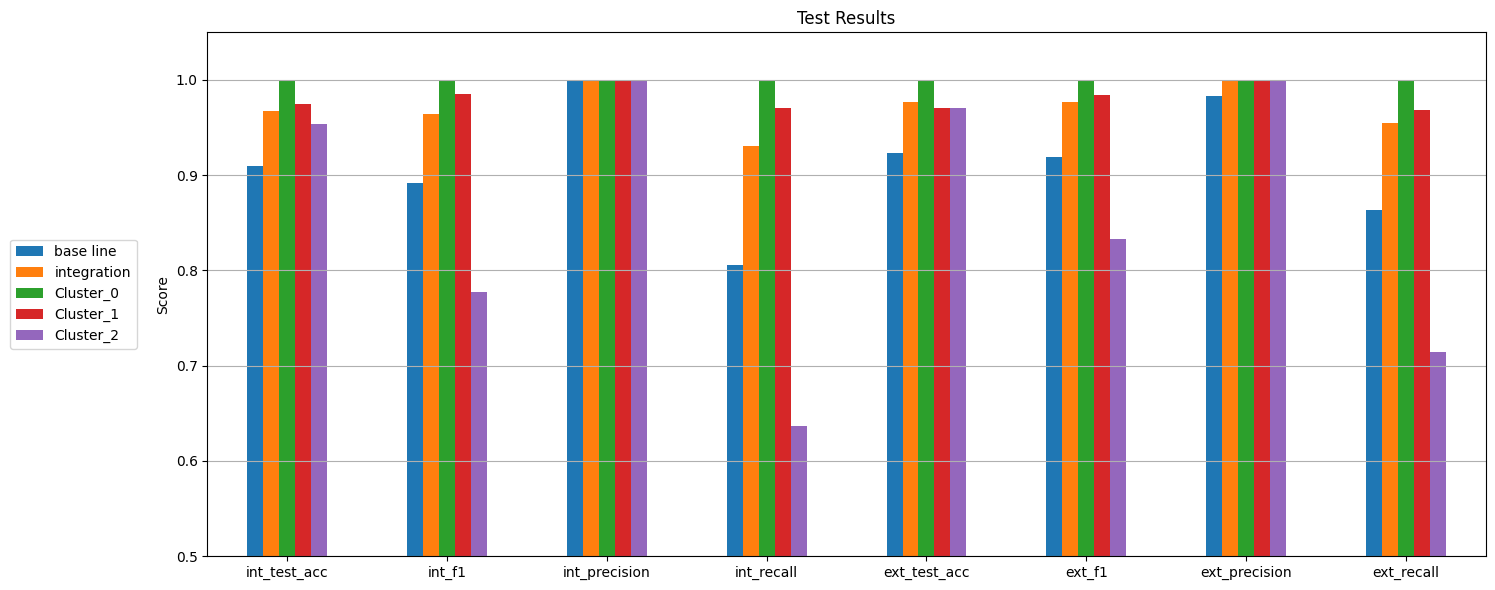

In [ ]:
metrics_int = ['base line',	'integration',	'Cluster_0',	'Cluster_1',	'Cluster_2']
total_test_result.T[metrics_int].plot(kind='bar', figsize=(15, 6), ylim=(0.5, 1.05), title='Test Results')
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='center right', bbox_to_anchor=(-0.05, 0.5))
plt.tight_layout()
plt.show()

### SHAP

In [ ]:
cluster_models

{np.int64(0): SVC(C=0.1, degree=2, kernel='linear', probability=True, random_state=42),
 np.int64(1): LogisticRegression(C=1, solver='liblinear'),
 np.int64(2): SVC(C=0.1, kernel='poly', probability=True, random_state=42)}

In [ ]:
from sklearn.inspection import permutation_importance
import shap

In [ ]:
Ds_project_folder_path

'/content/drive/MyDrive/DS_project/Data/'

In [ ]:

plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

In [ ]:

data_splits = {
    'Train': train_data,
    'Validation': val_data,
    'Internal Test': internal_test_data,
    'External Test': external_test_data
}

for split_name, test_df in data_splits.items():
    print(f"\n=== SHAP analysis: {split_name} ===")

    for cid in test_df['cluster'].unique():
        print(f"  🔹 Cluster {cid} processing...")

        model = cluster_models[np.int64(cid)]
        train_cluster_df = train_data[train_data['cluster'] == cid]
        test_cluster_df = test_df[test_df['cluster'] == cid]

        X_train = np.vstack(train_cluster_df['Factor_Array'].values)
        X_test = np.vstack(test_cluster_df['Factor_Array'].values)

        if X_train.shape[0] == 0 or X_test.shape[0] == 0:
            print(f"Data shortage - Cluster {cid} passed")
            continue

        if "SVC" in str(type(model)):
            if hasattr(model, "kernel") and model.kernel == 'linear':
                explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
            else:
                explainer = shap.KernelExplainer(model.predict_proba, shap.sample(X_train, 100))
        elif "LogisticRegression" in str(type(model)):
            explainer = shap.LinearExplainer(model, X_train, feature_perturbation="interventional")
        else:
            raise ValueError(f"Not supported model: {type(model)}")


        print(f"SHAP summary_plot for {split_name}, Cluster {cid}")
        shap_values = explainer.shap_values(X_test)

        if isinstance(shap_values, list):
            print(f"[INFO] SHAP is list → using class 1")
            shap_values = shap_values[1]

        elif isinstance(shap_values, np.ndarray):
            if shap_values.ndim == 3 and shap_values.shape[1] == shap_values.shape[2]:
                print(f"[INFO] Interaction shape → reducing to summary")
                shap_values = shap_values.sum(axis=1)
            elif shap_values.ndim == 3 and shap_values.shape[2] == 2:
                print(f"[INFO] Multi-class shape → using class 1")
                shap_values = shap_values[:, :, 1]

        shap.summary_plot(shap_values, X_test, show=False, plot_type="dot")
        plt.title(f"SHAP Summary - {split_name}, Cluster {cid}")
        plt.tight_layout()
        plt.savefig(f"{Ds_project_folder_path}9_Biological_Interpretation/9.2.SHAP/shap_summary_{split_name}_cluster{cid}.png", bbox_inches='tight')
        plt.clf()


=== SHAP analysis: Train ===
  🔹 Cluster 2 처리 중...
SHAP summary_plot for Train, Cluster 2


  0%|          | 0/308 [00:00<?, ?it/s]

[INFO] Multi-class shape → using class 1
  🔹 Cluster 1 처리 중...
SHAP summary_plot for Train, Cluster 1
  🔹 Cluster 0 처리 중...
SHAP summary_plot for Train, Cluster 0

=== SHAP analysis: Validation ===
  🔹 Cluster 2 처리 중...
SHAP summary_plot for Validation, Cluster 2


  0%|          | 0/59 [00:00<?, ?it/s]

[INFO] Multi-class shape → using class 1
  🔹 Cluster 1 처리 중...
SHAP summary_plot for Validation, Cluster 1
  🔹 Cluster 0 처리 중...
SHAP summary_plot for Validation, Cluster 0

=== SHAP analysis: Internal Test ===
  🔹 Cluster 2 처리 중...
SHAP summary_plot for Internal Test, Cluster 2


  0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Multi-class shape → using class 1
  🔹 Cluster 1 처리 중...
SHAP summary_plot for Internal Test, Cluster 1
  🔹 Cluster 0 처리 중...
SHAP summary_plot for Internal Test, Cluster 0

=== SHAP analysis: External Test ===
  🔹 Cluster 2 처리 중...
SHAP summary_plot for External Test, Cluster 2


  0%|          | 0/69 [00:00<?, ?it/s]

[INFO] Multi-class shape → using class 1
  🔹 Cluster 1 처리 중...
SHAP summary_plot for External Test, Cluster 1
  🔹 Cluster 0 처리 중...
SHAP summary_plot for External Test, Cluster 0


<Figure size 800x950 with 0 Axes>

In [ ]:
print(f"[DEBUG] {split_name} / Cluster {cid} → shap_values.shape = {np.shape(shap_values)}")

## Permutation

In [ ]:
def run_permutation_importance(model, X_test, y_test, test_name, scoring="accuracy", save_dir="./results"):
    print(f"\n[Permutation Importance] {test_name} set")

    if isinstance(X_test, pd.DataFrame):
        feature_names = X_test.columns
    else:
        feature_names = [f"Feature_{i}" for i in range(X_test.shape[1])]
        X_test = pd.DataFrame(X_test, columns=feature_names)

    result = permutation_importance(model, X_test, y_test, scoring=scoring, n_repeats=100, random_state=12)

    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std
    }).sort_values("importance_mean", ascending=False)

    print(importance_df.head(10))

    plt.figure(figsize=(8, 6))
    plt.barh(importance_df["feature"], importance_df["importance_mean"], xerr=importance_df["importance_std"])
    plt.gca().invert_yaxis()
    plt.xlabel("Mean Importance")
    plt.title(f"Permutation Importance - {test_name}")
    plt.tight_layout()

    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"permutation_importance_{test_name}.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.clf()

In [ ]:
data_splits = {
    'Train': train_data,
    'Validation': val_data,
    'Internal Test': internal_test_data,
    'External Test': external_test_data
}

for split_name, test_df in data_splits.items():
    if split_name in ['Train', 'Validation']:
        continue

    for cid in test_df['cluster'].unique():
        print(f"\n🔍 Permutation Importance - {split_name} / Cluster {cid}")

        model = cluster_models[np.int64(cid)]

        cluster_df = test_df[test_df['cluster'] == cid]
        X_test = np.vstack(cluster_df['Factor_Array'].values)
        y_test = cluster_df['label'].values

        if X_test.shape[0] == 0:
            print(f"⚠ 데이터 없음 - Cluster {cid} 건너뜀")
            continue

        run_permutation_importance(
            model,
            X_test,
            y_test,
            test_name=f"{split_name}_Cluster{cid}",
            scoring="accuracy",
            save_dir=f"{Ds_project_folder_path}9_Biological_Interpretation/9.2.SHAP"
        )


🔍 Permutation Importance - Internal Test / Cluster 2

[Permutation Importance] Internal Test_Cluster2 set
       feature  importance_mean  importance_std
2    Feature_2         0.114598        0.021957
7    Feature_7         0.036782        0.009195
15  Feature_15         0.009195        0.004598
20  Feature_20         0.008851        0.005597
13  Feature_13         0.006092        0.007703
9    Feature_9         0.005287        0.007346
25  Feature_25         0.003333        0.005463
19  Feature_19         0.001954        0.004318
26  Feature_26         0.000230        0.001609
23  Feature_23         0.000115        0.001144

🔍 Permutation Importance - Internal Test / Cluster 1

[Permutation Importance] Internal Test_Cluster1 set
     feature  importance_mean  importance_std
2  Feature_2          0.20100        0.047555
9  Feature_9          0.00075        0.004265
1  Feature_1          0.00000        0.000000
3  Feature_3          0.00000        0.000000
4  Feature_4          0.0000

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>